# SBM learning


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = set_device(verbose=True)
#device = torch.device('cpu')

Using backend: pytorch


cuda available


# Stochastic block model

In [2]:
class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

In [3]:
from SBM import SBMsDataset
DATASET_NAME = 'SBM_CLUSTER'
dataset = SBMsDataset(DATASET_NAME)  # 54s
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] Loading dataset SBM_CLUSTER...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 14.9953s


## Visualise the dataset

Label: tensor([2, 2, 2, 2, 1, 0, 4, 3, 3, 1, 1, 3, 1, 2, 4, 5, 2, 3, 5, 1, 4, 3, 0, 1,
        0, 1, 3, 2, 2, 3, 3, 0, 1, 4, 2, 0, 0, 2, 5, 2, 5, 4, 3, 5, 2, 1, 1, 2,
        5, 5, 2, 0, 2, 1, 2, 3, 0, 3, 0, 5, 5, 0, 4, 3, 3, 1, 2, 1, 4, 2, 4, 2,
        5, 4, 3, 0, 2, 3, 3, 3, 2, 2, 4, 0, 0, 3, 5, 3, 5, 1, 2, 5, 2, 3, 4, 3,
        0, 4, 0, 1, 0, 1, 0, 4, 5, 1, 2, 0, 3, 4, 5, 4, 3, 4, 1, 2, 2, 1, 3, 5,
        4, 3, 0, 0, 1, 2, 0, 4, 0, 1, 3, 1, 1, 3, 3], dtype=torch.int16)
graph: DGLGraph(num_nodes=135, num_edges=5606,
         ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
Largest eigenvalue: 1.2609009928975539
Smallest eigenvalue: 1.0933292411528468e-17


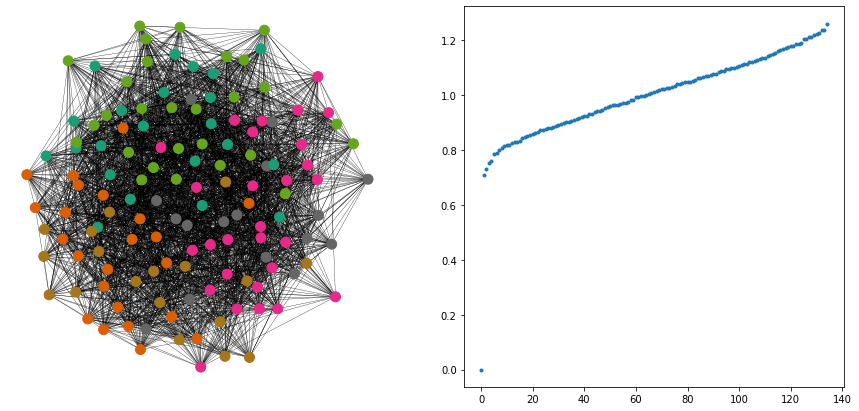

In [4]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo = trainset[random.randrange(100)]
nx.draw_spring(g_demo.to_networkx().to_undirected(),
        node_color= l_demo, # g_demo.ndata['feat'],
        node_size=100,
        width= .3,
        cmap='Dark2',
        iter = 250)

print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()

In [5]:
g_demo.ndata['feat']

tensor([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6,
        5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

/home/axel/anaconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


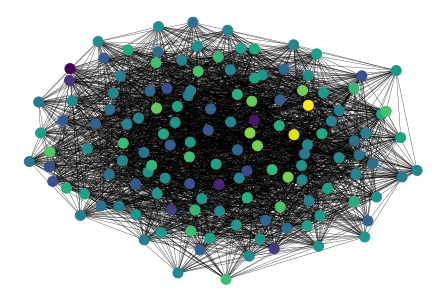

In [6]:
from utils import chebyshev
from laplacian import normalized_laplacian
L = normalized_laplacian(g_demo).to_dense()
Fmap = chebyshev(L,g_demo.ndata['feat'].view(-1,1).float() ,10)

nx.draw(g_demo.to_networkx().to_undirected(),
        node_color=Fmap[9].squeeze(),
        node_size=100,
        width= .3)

# Model definition for training

In [7]:
from model_SBM import Cheb_SBM
# model_parameters
in_features = 1 
conv_out = 128
hidden_layer_classifier = 128
k = 4
n_classes = 6

net = Cheb_SBM(
    in_features, 
    conv_out, 
    hidden_layer_classifier, 
    n_classes, 
    k,
    readout="mean"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Cheb_SBM(
  (layers): ModuleList(
    (0): Cheb_Conv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=4, out_features=128, bias=True)
      )
    )
    (1): Cheb_Conv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=512, out_features=256, bias=True)
      )
    )
    (2): Cheb_Conv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
    (3): Cheb_Conv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
  )
  (MLP): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=6, bias=True)
  )
)


In [8]:
from utils import load_model
#net.load_state_dict(load_model('Cheb_superpix_overfit'))

# Training pipe

In [9]:
def collate2(samples):
    '''
    Function that helps with the overall collation of graph, signals and labels

    Return
    ----------
    Batched graph, labels (torch.tensor), signals (torch.tensor)
    
    '''
    # The input `samples` is a list of pairs
    #  (graph, label, signal).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.cat(labels).long()

In [10]:
import torch.optim as optim
import torch.nn as nn
#
#from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=50,
                         shuffle=True, collate_fn = collate2, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=500,
                         shuffle=False, collate_fn= collate2, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=500,
                         shuffle=False, collate_fn= collate2, drop_last=True, pin_memory=True)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

epoch_losses = []

In [11]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        tot_len = 0
        t0 = time.time()

        for iter, (bGraph, label) in enumerate(data_loader):
            #print(iter)
            #print('graph', bGraph)
            #print('label',label,label.size())
            #print(bGraph.is_readonly)
            
            tot_len += bGraph.number_of_nodes()
            bGraph, label = bGraph.to(device), label.to(device)
            signal = bGraph.ndata.pop('feat').float().to(device)
            output = model(bGraph, signal)
            
            loss = model.loss(output, label)
            #loss = loss_func(output, label.to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1
        
        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {} loss - train {:.4f} - val {:.4f} - Acc: {} ({:.1f}%) in {:.1f}s".format(
                epoch, epoch_loss, val_loss, correct,
            100 * correct / tot_len, time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [12]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (Bgraph, label) in enumerate(data_loader):
            Bgraph, label = Bgraph.to(device), label.to(device)

            output = model(Bgraph, Bgraph.ndata['feat'].float())
            # sum up batch loss
            test_loss += model.loss(output, label.to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
            
            #tot_label.append(label.cpu())
            #tot_pred.append(pred.cpu())

    # for the classification report
    #print('label',label,len(label),'tot',tot_label, len(tot_label))
    #tot_label = torch.stack(tot_label).view(-1).cpu()
    #tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f},Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        #import sklearn
        #from sklearn.metrics import classification_report

        #print(sklearn.metrics.classification_report(tot_label, tot_pred))

    else:
        return test_loss

## Training time

In [18]:
train(net, device, train_loader, 10, loss_func,optimizer, scheduler)

Epoch 0 loss - train 1.0595 - val 1.0432 - Acc: 711306 (60.8%) in 369.2s
Epoch 1 loss - train 1.0467 - val 1.0348 - Acc: 717679 (61.3%) in 380.0s
Epoch 2 loss - train 1.0328 - val 1.0284 - Acc: 723898 (61.8%) in 376.8s
Epoch 3 loss - train 1.0217 - val 1.0148 - Acc: 728831 (62.3%) in 367.3s
Epoch 4 loss - train 1.0162 - val 1.0236 - Acc: 731320 (62.5%) in 373.4s
Epoch 5 loss - train 1.0053 - val 1.0005 - Acc: 736426 (62.9%) in 371.5s
Epoch 6 loss - train 0.9981 - val 0.9926 - Acc: 739622 (63.2%) in 329.5s
Epoch 7 loss - train 0.9888 - val 0.9905 - Acc: 743768 (63.5%) in 264.0s
Epoch 8 loss - train 0.9837 - val 0.9878 - Acc: 745895 (63.7%) in 263.7s
Epoch 9 loss - train 0.9789 - val 0.9788 - Acc: 748481 (63.9%) in 268.4s


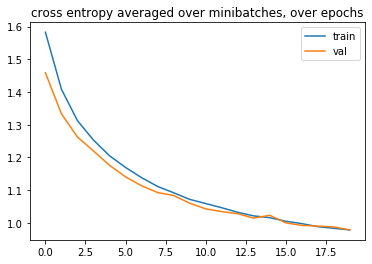

In [19]:
plt.title("cross entropy averaged over minibatches, over epochs")
plt.plot(epoch_losses)
plt.legend(['train','val'])
plt.show()

In [20]:
torch.cuda.empty_cache()

## Test Metrics

In [21]:
test(net,device,test_loader)
torch.cuda.empty_cache()

/home/axel/anaconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)



 Average loss per epoch: 0.9619,Accuracy: 74986/1000 (7499%)



## Saving

In [22]:
from utils import save_model

save_model("SBM/Cheb_mean", net)